# Anomaly Detection with Autoencoder in PyTorch - TEST FOR WPAD PROJECT 

This file contains extactly the same structure of FinalWork with the best achied results using RandomForest 

The purpose of the project is to perform anomaly detection on the dataset "Water Pump Audio for Anomaly Detection." The procedure is as follows: After loading the audio files, STFT features are extracted from each one. Next, data normalization is conducted using an LSTM Autoencoder to extract a latent space representation of the feature vectors. Once this representation is obtained, anomaly detection approaches are applied in this latent space, starting from a naive threshold-based predictor and advancing to machine learning models optimized for their parameters.

In [69]:
import os

dataset_base_path = "./water pump audio for anomaly detection/"
train_normal_path = os.path.join(dataset_base_path, "train-normal")
test_normal_path = os.path.join(dataset_base_path, "test-normal")
anomaly_path = os.path.join(dataset_base_path, "anomaly")

In [70]:
import librosa
import numpy as np

def load_audio_files(path, sr=22050, duration=10):
    audio_files = []
    for file in os.listdir(path):
        if file.endswith(".wav"):
            file_path = os.path.join(path, file)
            audio, _ = librosa.load(file_path, sr=sr, duration=duration)
            audio_files.append(audio)
    return np.array(audio_files)

In [71]:
train_normal_files = load_audio_files(train_normal_path)
test_normal_files = load_audio_files(test_normal_path)
anomaly_files = load_audio_files(anomaly_path)

In [72]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def extract_stft_features(audio_files, n_fft = 2048, hop_length = 512):
    stft_features = []
    for audio in audio_files:
        # Length of FFT window
        # Number of samples between successive frames
        stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        spectrogram = np.abs(stft)
        # Convert the complex values to magnitude
        stft_features.append(spectrogram)
    return np.array(stft_features)


train_normal_stft = extract_stft_features(train_normal_files)
test_normal_stft = extract_stft_features(test_normal_files)
anomaly_stft = extract_stft_features(anomaly_files)

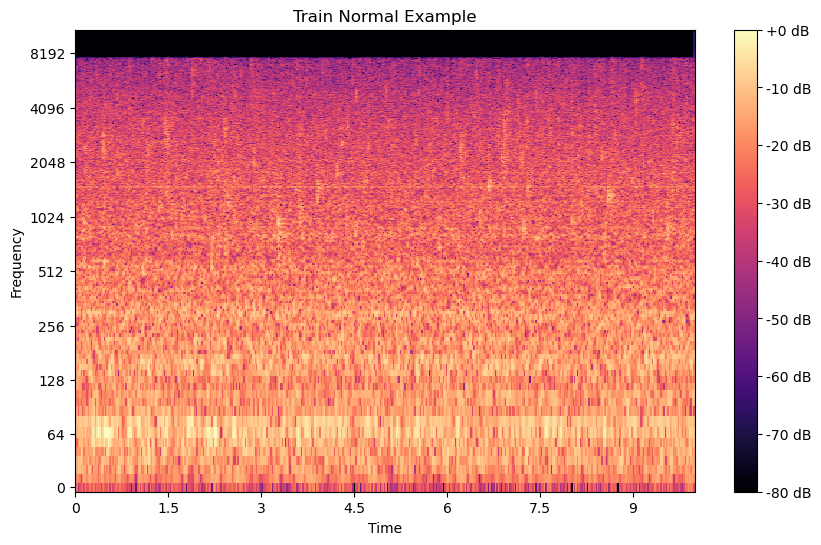

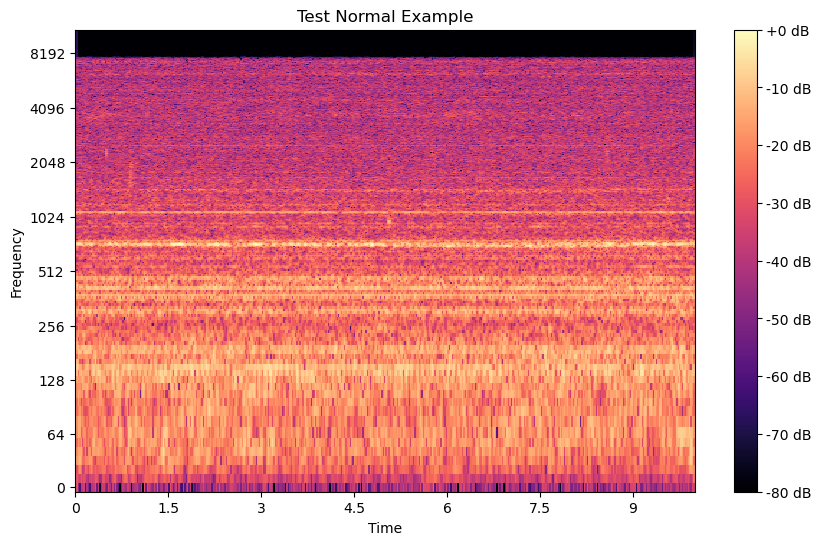

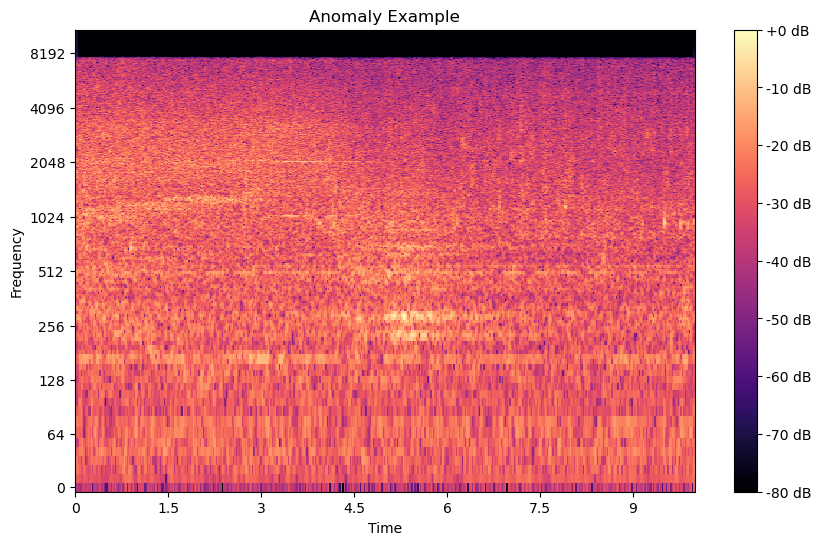

In [73]:
# Plot dello spettrogramma

# Funzione per calcolare e visualizzare lo spettrogramma di un file audio
def plot_spectrogram(spectrogram, title, sr=22050, hop_length=512):

    # Plot dello spettrogramma
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                             sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

# Esempio di utilizzo della funzione
train_normal_example = train_normal_stft[0]  # Primo esempio del dataset train normal
plot_spectrogram(train_normal_example, "Train Normal Example")
test_normal_example = test_normal_stft[0]  # Primo esempio del dataset train normal
plot_spectrogram(test_normal_example, "Test Normal Example")
anomaly_example = anomaly_stft[0]  # Primo esempio del dataset train normal
plot_spectrogram(anomaly_example, "Anomaly Example")


In [74]:
print(train_normal_stft.shape)
print(test_normal_stft.shape)
print(anomaly_stft.shape)

train_normal_stft = train_normal_stft.transpose(0, 2, 1)
test_normal_stft = test_normal_stft.transpose(0, 2, 1)
anomaly_stft = anomaly_stft.transpose(0, 2, 1)

print(train_normal_stft.shape)
print(test_normal_stft.shape)
print(anomaly_stft.shape)

(2241, 1025, 431)
(400, 1025, 431)
(456, 1025, 431)
(2241, 431, 1025)
(400, 431, 1025)
(456, 431, 1025)


In [75]:
# Normalizzazione dei dati
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_normal_stft_scaled = scaler.fit_transform(train_normal_stft.reshape(-1, train_normal_stft.shape[-1])).reshape(train_normal_stft.shape)
test_normal_stft_scaled = scaler.transform(test_normal_stft.reshape(-1, test_normal_stft.shape[-1])).reshape(test_normal_stft.shape)
anomaly_stft_scaled = scaler.transform(anomaly_stft.reshape(-1, anomaly_stft.shape[-1])).reshape(anomaly_stft.shape)

print(train_normal_stft.shape)
print(test_normal_stft.shape)
print(anomaly_stft.shape)


(2241, 431, 1025)
(400, 431, 1025)
(456, 431, 1025)


In [76]:
# sftf autoencoder

import tensorflow as tf
from tensorflow.keras import layers, models

# Input dimensions
time_steps = 431  # Number of time frames
n_stft = 1025    # Number of MFCC coefficients
latent_dim = 64   # Dimension of the latent space

# Encoder
encoder_inputs = tf.keras.Input(shape=(time_steps, n_stft))
encoded = layers.LSTM(128, return_sequences=True)(encoder_inputs)
encoded = layers.LSTM(latent_dim, return_sequences=False)(encoded)

# Decoder
decoded = layers.RepeatVector(time_steps)(encoded)
decoded = layers.LSTM(128, return_sequences=True)(decoded)
decoded = layers.LSTM(n_stft, return_sequences=True)(decoded)

# Autoencoder
autoencoder_stft = models.Model(encoder_inputs, decoded, name="Recurrent_Autoencoder")

# Encoder model (for extracting latent space representation)
latent_model_stft = models.Model(encoder_inputs, encoded, name="Encoder")

# Compile the autoencoder
autoencoder_stft.compile(optimizer='adam', loss='mse')

autoencoder_stft.summary()
latent_model_stft.summary()

Model: "Recurrent_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 431, 1025)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 431, 128)       │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 431, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 431, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 431, 1025)      │     4,731,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,470,472 (20.87 MB)

 Trainable params: 5,470,472 (20.87 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 431, 1025)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 431, 128)       │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,256 (2.44 MB)

 Trainable params: 640,256 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder_stft.fit(
    train_normal_stft_scaled,
    train_normal_stft_scaled,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - loss: 0.0011 - val_loss: 7.3345e-04
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - loss: 7.1597e-04 - val_loss: 6.7724e-04
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - loss: 6.5665e-04 - val_loss: 6.4111e-04
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - loss: 6.3647e-04 - val_loss: 6.2298e-04
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - loss: 6.1645e-04 - val_loss: 6.1538e-04
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - loss: 6.0344e-04 - val_loss: 6.1919e-04
Epoch 7/30
48/56 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 6.2162e-04

In [22]:
import tensorflow.keras.models as models

models.save_model(autoencoder_stft, 'autoencoder_stft.h5')
models.save_model(autoencoder_stft, 'autoencoder_stft.keras')


In [21]:
reconstructed_test = autoencoder_stft.predict(test_normal_stft_scaled)
reconstructed_anomaly = autoencoder_stft.predict(anomaly_stft_scaled)

# Calculate Mean Squared Error (MSE) for reconstruction loss
test_loss = np.mean(np.square(test_normal_stft_scaled - reconstructed_test), axis=(1, 2))
anomaly_loss = np.mean(np.square(anomaly_stft_scaled - reconstructed_anomaly), axis=(1, 2))

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


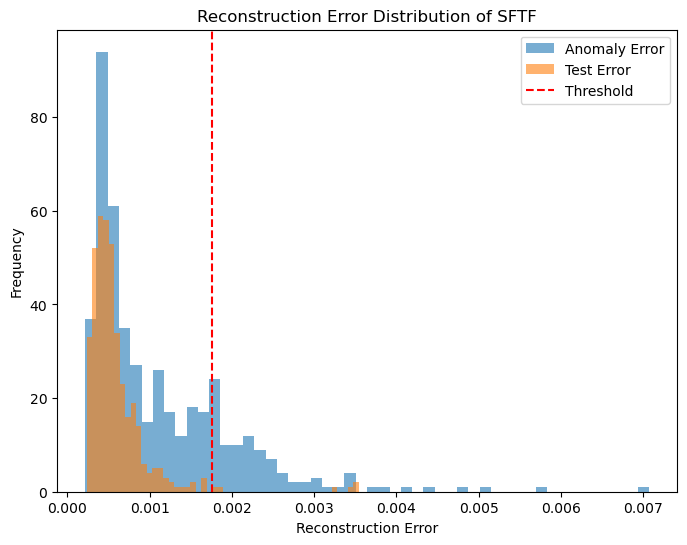

In [23]:
import matplotlib.pyplot as plt

# Plot histogram of reconstruction errors
plt.figure(figsize=(8, 6))
plt.hist(anomaly_loss, bins=50, alpha=0.6, label='Anomaly Error')
plt.hist(test_loss, bins=50, alpha=0.6, label='Test Error')
plt.axvline(np.mean(test_loss) + 3 * np.std(test_loss), color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution of SFTF")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [24]:
train_sftf_latent = latent_model_stft.predict(train_normal_stft_scaled)
test_sftf_latent = latent_model_stft.predict(test_normal_stft_scaled)
anomaly_sftf_latent = latent_model_stft.predict(anomaly_stft_scaled)

print(train_sftf_latent.shape)
print(test_sftf_latent.shape)
print(anomaly_sftf_latent.shape)

71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step
(2241, 64)
(400, 64)
(456, 64)


In [53]:
import sklearn.utils as sk_utils
# Combine data and create labels (normal: 0, anomaly: 1)
index_train = np.random.choice(train_sftf_latent.shape[0], 400, replace=False)
index_test = np.random.choice(test_sftf_latent.shape[0], 200, replace=False)
index_anomaly = np.random.choice(anomaly_sftf_latent.shape[0], 200, replace=False)

X_train = np.concatenate([train_sftf_latent[index_train], test_sftf_latent[index_test], anomaly_sftf_latent[index_anomaly]], axis=0)
y_train = np.concatenate([np.zeros(400 + 200), np.ones(200)], axis=0)

X_train, y_train = sk_utils.shuffle(X_train, y_train)

In [59]:
# Selezione degli indici complementari per test e anomaly
complementary_index_train = np.setdiff1d(np.arange(train_sftf_latent.shape[0]), index_train)
complementary_index_test = np.setdiff1d(np.arange(test_sftf_latent.shape[0]), index_test)
complementary_index_anomaly = np.setdiff1d(np.arange(anomaly_sftf_latent.shape[0]), index_anomaly)

# Creazione di X_test
X_test = np.concatenate([train_sftf_latent[complementary_index_train], test_sftf_latent[complementary_index_test], anomaly_sftf_latent[complementary_index_anomaly]], axis=0)

# Creazione di y_test (0 per normal, 1 per anomaly)
y_test = np.concatenate([np.zeros(len(complementary_index_train)), np.zeros(len(complementary_index_test)), np.ones(len(complementary_index_anomaly))], axis=0)

# Output della dimensione dei dati per verifica
print(f"Dimensioni X_test: {X_test.shape}")
print(f"Dimensioni y_test: {y_test.shape}")


Dimensioni X_test: (2297, 64)
Dimensioni y_test: (2297,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score


pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))  # Step 2: Random Forest
])

# Define hyperparameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Number of trees
    'classifier__max_depth': [None, 10, 20, 30],  # Tree depth
    'classifier__min_samples_split': [2, 5, 10],  # Min samples to split a node
    'classifier__min_samples_leaf': [1, 2, 4],  # Min samples in a leaf node
    'classifier__bootstrap': [True, False]  # Whether to bootstrap samples
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Use ROC-AUC as the evaluation metric
    n_jobs=-1,  # Use all available CPU cores
    verbose=2
)

# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation ROC-AUC Score:", grid_search.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.6s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.7s
[CV] END classifier__bootstrap=True, classifie

In [ ]:
# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Evaluate performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC-AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"Test ROC-AUC Score: {auc_score:.2f}")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2041
         1.0       0.99      0.89      0.94       256

    accuracy                           0.99      2297
   macro avg       0.99      0.94      0.96      2297
weighted avg       0.99      0.99      0.99      2297

Test ROC-AUC Score: 1.00


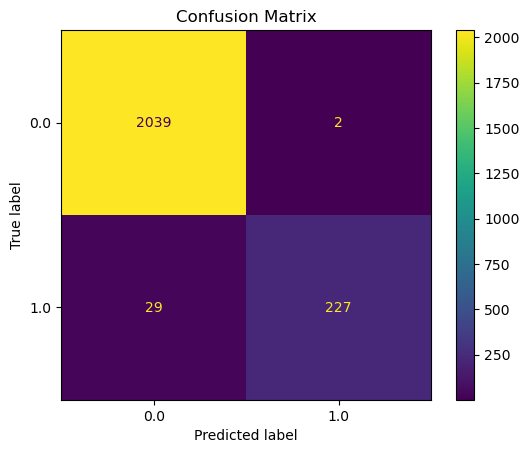

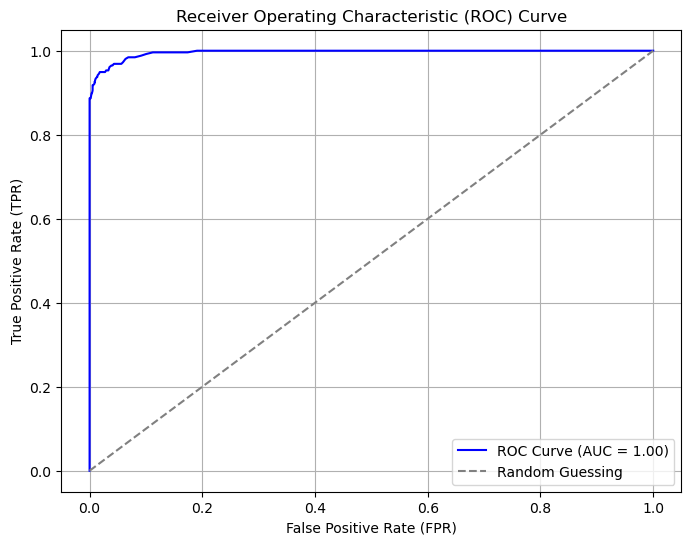


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2041
         1.0       0.99      0.89      0.94       256

    accuracy                           0.99      2297
   macro avg       0.99      0.94      0.96      2297
weighted avg       0.99      0.99      0.99      2297


ROC-AUC Score: 1.00


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, classification_report

# Confusion matrix
# Usa y_pred (classi predette) per creare la matrice di confusione
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
# Usa y_prob (probabilità predette per la classe positiva) per generare la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)  # Calcola l'Area Under the Curve (AUC)

# Plot della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guessing")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Classification Report
# Usa y_pred per generare un rapporto di classificazione
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
# Usa y_prob per calcolare il ROC-AUC score
roc_auc_score_value = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {roc_auc_score_value:.2f}")


In [65]:
from sklearn.svm import SVC

# Train an SVM classifier
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm.predict(X_test)

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, svm.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", roc_auc)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2041
         1.0       1.00      0.28      0.44       256

    accuracy                           0.92      2297
   macro avg       0.96      0.64      0.70      2297
weighted avg       0.93      0.92      0.90      2297

Confusion Matrix:
 [[2041    0]
 [ 184   72]]
ROC-AUC Score: 0.906470097378736


In [ ]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
clf = IsolationForest(n_estimators=100, contamination=0.15, random_state=42)
clf.fit(X_train)


IsolationForest(contamination=0.15, random_state=42)

In [68]:
# Predict anomaly scores for test data
anomaly_scores = clf.decision_function(X_test)  # Higher is more normal
predictions = clf.predict(X_test)  # -1 for anomaly, 1 for normal

# Convert predictions to binary classification (0: normal, 1: anomaly)
binary_predictions = [1 if x == -1 else 0 for x in predictions]



In [33]:
from sklearn.metrics import classification_report, roc_auc_score

# Classification report
print(classification_report(y_test, binary_predictions, target_names=["Normal", "Anomaly"]))

# AUC-ROC score
auc_score = roc_auc_score(y_test, anomaly_scores)
print(f"AUC-ROC Score: {auc_score:.2f}")


              precision    recall  f1-score   support

      Normal       0.88      0.84      0.86       542
     Anomaly       0.14      0.18      0.15        78

    accuracy                           0.75       620
   macro avg       0.51      0.51      0.51       620
weighted avg       0.78      0.75      0.77       620

AUC-ROC Score: 0.45


In [34]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

X_train_normal = X_train[y_train == 0]
# Create and fit the One-Class SVM
oc_svm = OneClassSVM(kernel="rbf", nu=0.05, gamma="scale")
oc_svm.fit(X_train_normal)


OneClassSVM(nu=0.05)

In [35]:
# Predict on the test set
y_pred = oc_svm.predict(X_test)
binary_predictions = (y_pred == -1).astype(int)  # Convert -1 to anomaly (1)

# Get anomaly scores (distance from the decision boundary)
anomaly_scores = oc_svm.decision_function(X_test)


In [36]:
# Classification report
print(classification_report(y_test, binary_predictions, target_names=["Normal", "Anomaly"]))

# AUC-ROC Score
auc_score = roc_auc_score(y_test, anomaly_scores)
print(f"AUC-ROC Score: {auc_score:.2f}")


              precision    recall  f1-score   support

      Normal       0.88      0.94      0.91       542
     Anomaly       0.23      0.12      0.15        78

    accuracy                           0.84       620
   macro avg       0.56      0.53      0.53       620
weighted avg       0.80      0.84      0.82       620

AUC-ROC Score: 0.43


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Train Logistic Regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of being anomaly

# Evaluate
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob):.2f}")

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       542
         1.0       1.00      0.15      0.27        78

    accuracy                           0.89       620
   macro avg       0.95      0.58      0.60       620
weighted avg       0.91      0.89      0.86       620

AUC-ROC Score: 0.82
